# A Non-Judgmental Analysis for PCA


As mentioned on the exam, due to the opinion of the data scientists I have worked with and what they say about PCA (skews the data, brings down the accuracy etc.) I have had my prejudices not to use it. But because of that my knowledge of PCA was purely a theoretical one meaning I did not actually know what the outcome would be. Therefore, I will give it a chance to better understand without any other opinions.

The Goal: Predicting the Drug

The Plan Breakdown:
>1) Exploring & Preprocessing:
>>• missing data and outliers,
>>>• data spread,
>>>>• column names and values,
>>>>>• checking for the columns that will be encoded later
>2) Label Encoder
>3) PCA:
>>• Standardise (with Robust Scaler)
>>>• PCA
>4) Machine Learning Models
>5) Evaluation


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
import warnings
warnings.filterwarnings('ignore')

In [131]:
drugs=pd.read_csv('drug200.csv', delimiter=',', index_col=False)
drugs.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [132]:
print('Eligible for Encoding with', len(drugs.Sex.unique()) ,'values:',drugs.Sex.unique())
print('Eligible for Encoding with', len(drugs.BP.unique()) ,'values:',drugs.BP.unique())
print('Eligible for Encoding with', len(drugs.Cholesterol.unique()) ,'values:',drugs.Cholesterol.unique())
print('Eligible for Encoding with', len(drugs.Drug.unique()) ,'values:',drugs.Drug.unique())

Eligible for Encoding with 2 values: ['F' 'M']
Eligible for Encoding with 3 values: ['HIGH' 'LOW' 'NORMAL']
Eligible for Encoding with 2 values: ['HIGH' 'NORMAL']
Eligible for Encoding with 5 values: ['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


>>From this view, it is clear that we can encode almost of the columns which makes machine learning model for the later stage a breeze.

Let's check if there is any missing data and the data types before we get into PCA.

In [133]:
print('--Amount of Missing Data--')
print(drugs.isna().sum())
print('--Data Types--')
print(drugs.dtypes)



--Amount of Missing Data--
Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64
--Data Types--
Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object


## OUTLIERS

One last step is to check if there are any outliers within the 'Na_to_K' column (the only column with quantitative data). This will determine the standardising function we will use later.

Interquartile Range is 8.9345
Upper bound outliers: 8 [33.486, 38.247, 35.639, 33.542, 32.922, 37.188, 34.997, 34.686]
Lower bound outliers: 0


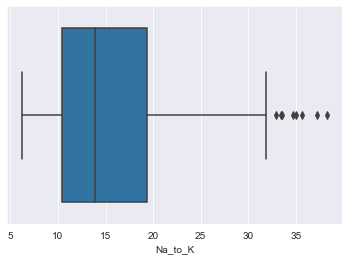

In [226]:
sns.boxplot(drugs['Na_to_K'])
Q1 = np.percentile(drugs['Na_to_K'], 25)
Q3 = np.percentile(drugs['Na_to_K'], 75)
IQR = Q3 - Q1
print('Interquartile Range is',IQR)

# Above Upper bound
upper_outlier = [x for x in drugs['Na_to_K'] if x >= (Q3+1.5*IQR)]

print("Upper bound outliers:",len(upper_outlier),upper_outlier)


# Below Lower bound
lower_outlier=  [x for x in drugs['Na_to_K'] if x <= (Q1-1.5*IQR)]
print("Lower bound outliers:", len(lower_outlier))




In [ ]:
encode = LabelEncoder()
drugs['Drug']= encode.fit_transform(drugs['Drug'])
drugs['Cholesterol']= encode.fit_transform(drugs['Cholesterol'])
drugs['BP']= encode.fit_transform(drugs['BP'])
drugs['Sex']= encode.fit_transform(drugs['Sex'])

After encoding labels, we then check the correlation matrix to understand the relations of the columns.

"PCA should be used mainly for variables which are strongly correlated. If the relationship is weak between variables, PCA does not work well to reduce data. Refer to the correlation matrix to determine. In general, if most of the correlation coefficients are smaller than 0.3, PCA will not help."

                  Age       Sex        BP  Cholesterol   Na_to_K      Drug
Age          1.000000  0.102027  0.054212    -0.068234 -0.063119  0.041856
Sex          0.102027  1.000000 -0.007814    -0.008811 -0.125008  0.018239
BP           0.054212 -0.007814  1.000000    -0.137552 -0.149312  0.419397
Cholesterol -0.068234 -0.008811 -0.137552     1.000000  0.010000  0.048415
Na_to_K     -0.063119 -0.125008 -0.149312     0.010000  1.000000 -0.689051
Drug         0.041856  0.018239  0.419397     0.048415 -0.689051  1.000000


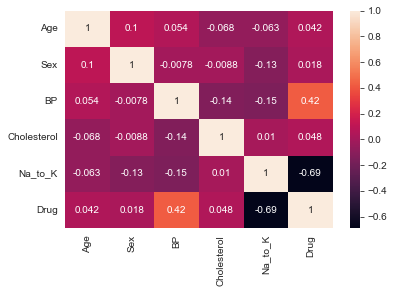

In [154]:
corr_matrix = drugs.corr()
print(corr_matrix)

sns.heatmap(corr_matrix, annot=True)
plt.show()

In [227]:

# Let's mark our features and labels before any standardisation
features = drugs.drop('Drug',axis = 1)
labels = np.asarray(drugs.Drug)
print('- There are', len(labels[labels == 0]), 'from first drug class.')
print('- There are',len(labels[labels == 1]), 'from second drug class.')
print('- There are',len(labels[labels == 2]), 'from third drug class.')
print('- There are',len(labels[labels == 3]), 'from fourth drug class.')
print('- There are',len(labels[labels == 4]), 'from fifth drug class.')


- There are 91 from first drug class.
- There are 23 from second drug class.
- There are 16 from third drug class.
- There are 16 from fourth drug class.
- There are 54 from fifth drug class.


|| Unfortunate class imbalance above.

# STANDARDISING AND PCA


### There are different scalers: minmax, robust and standard:

**StandardScaler** removes the mean and scales the data to unit variance.
**MinMaxScaler** rescales the data set such that all feature values are in the range [0, 1]
!!Both are extremely sensitive to outliers.!!
Considering that we have 8 upper bound outliers, it is sensible to use **RobustScaler**. Unlike the previous scalers, the centering and scaling statistics of **RobustScaler** are based on percentiles and are therefore not influenced by a small number of very large marginal outliers. In our case 4% of the data.

In [158]:
scaler = RobustScaler()
features_standardised = scaler.fit_transform(features)

The reason why it is critical to perform standardization prior to PCA, is that the latter is quite sensitive regarding the variances of the initial variables. That is, if there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges (For example, a variable that ranges between 0 and 100 will dominate over a variable that ranges between 0 and 1), which will lead to biased results.
In our example, this is only necessary for the float data type column which is Na_to_K due to all the other ones being encoded integers.

# The Moment of Truth: PCA

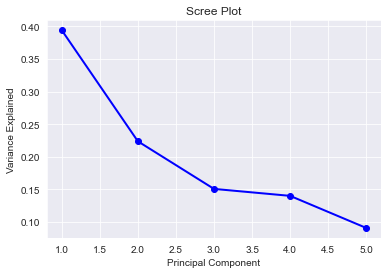

[0.39385658 0.22378084 0.15091929 0.1402711  0.09117219]
0.9999999999999999


In [159]:
#define PCA model to use
pca = PCA(n_components=5)

#fit PCA model to data
pca_fit = pca.fit_transform(features_standardised)


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

As we have seen from the correlation matrix above and explained variance ratio, there is definitely not a strong relationship or dominance within the data which makes it hard to reduce the dimensionality without jeopardising the interpretability. On an actual business project, my humble opinion would be that this data is not a good fit for PCA (this is kind of my luck). However, as we are experimenting and due to the potential time constraint finding another dataset with 3 criteria (classification, csv -for better visibility- and PCA friendly) I will continue regardless and have two models; one making use of the standardised and PCA applied and another unprocessed one for control for prediction accuracy differences.

# MACHINE LEARNING MODELS

## Train Test Split

In [ ]:
#Two Splits; one with PCA, one without any feature extraction
x_train_pca,x_test_pca,y_train_pca, y_test_pca= train_test_split(pca_fit,labels,test_size=0.20, random_state=42)
x_train,x_test,y_train, y_test= train_test_split(features,labels,test_size=0.20, random_state=42)


The best way to test out different models to choose is to feed them all into the same pipeline and then decide. We will use KNN, Random Forest (likely to overfit), Support Vector Classifier and Logistic Regression.

In [201]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "SVC": SVC(),
          "Logistic Regression": LogisticRegression()}


# Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores



In [228]:
model_scores = fit_and_score(models=models,
                             x_train=x_train,
                             x_test=x_test,
                             y_train=y_train,
                             y_test=y_test
                             )
model_scores_pca = fit_and_score(models=models,
                             x_train=x_train_pca,
                             x_test=x_test_pca,
                             y_train=y_train_pca,
                             y_test=y_test_pca
                             )
print('Accuracy for raw data by model',model_scores)
print('Accuracy for PCA data by model',model_scores_pca)



Accuracy for raw data by model {'KNN': 0.7, 'Random Forest': 1.0, 'SVC': 0.625, 'Logistic Regression': 0.8}
Accuracy for PCA data by model {'KNN': 0.925, 'Random Forest': 0.925, 'SVC': 1.0, 'Logistic Regression': 0.85}


> The most stable out of 4 different models seem to be Logistic Regression. I will zoom into evaluation metrics with that model again using two sets of data (PCA and normal).

In [229]:
model_logistic = LogisticRegression()

model_logistic.fit(x_train, y_train)
y_pred=model_logistic.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      0.50      0.67         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         5
           4       0.73      1.00      0.85        11

    accuracy                           0.80        40
   macro avg       0.70      0.70      0.68        40
weighted avg       0.72      0.80      0.74        40



In [230]:
model_logistic = LogisticRegression()

model_logistic.fit(x_train_pca, y_train_pca)
y_pred_pca=model_logistic.predict(x_test_pca)

print(classification_report(y_test_pca, y_pred_pca))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         5
           4       0.77      0.91      0.83        11

    accuracy                           0.85        40
   macro avg       0.70      0.78      0.74        40
weighted avg       0.75      0.85      0.79        40



Although both of the data was able to be correctly interpreted, the imbalance in the dataset shows its ugly head here. On both of the datasets (with or without PCA), it is not able to predict the fourth class (see 3) at all.
This calls for cross validation to ensure the split includes an (almost) equal representation of each class.

In [235]:

scores = cross_val_score(model_logistic,features,labels,cv=5, scoring='f1_macro')
scores


array([0.87869919, 0.7461039 , 0.65888889, 0.75771127, 0.84337974])

In [249]:
pred= cross_val_predict(model_logistic,features,labels,cv=5)
pred_pca= cross_val_predict(model_logistic,pca_fit,labels,cv=5)
print('        ----------------------------------------------')
print('          •The Raw model with Cross Validation')
print('        ----------------------------------------------')
print(classification_report(labels, y_pred))
print('        ----------------------------------------------')
print('           •The PCA model with Cross Validation')
print('        ----------------------------------------------')
print(classification_report(labels, y_pred_pca))

        ----------------------------------------------
          •The Raw model with Cross Validation
        ----------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        91
           1       0.79      0.65      0.71        23
           2       0.71      0.75      0.73        16
           3       1.00      0.44      0.61        16
           4       0.90      0.98      0.94        54

    accuracy                           0.87       200
   macro avg       0.86      0.76      0.78       200
weighted avg       0.87      0.87      0.86       200

        ----------------------------------------------
           •The PCA model with Cross Validation
        ----------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        91
           1       0.82      1.00      0.90        23
           2       0.85      0.69

### This **WAS** an educated guess that paid off with our 4th class metrics appearing here.
Although overall the PCA model is performing a tiny bit better, the raw model is handling the 4th class much better. In classification problems it is always much wiser to check f1-score more than accuracy.

Easter egg:

 <img src="https://preview.redd.it/5iue845oa8x01.png?auto=webp&s=9bc5012d54633542f178fc0510748e6a98d735a1">